In [102]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

pd.options.mode.chained_assignment = None
plt.style.use('classic')
plt.style.use('seaborn-ticks')
plt.style.use('seaborn-darkgrid')
plt.style.use('dark_background')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/reviews.csv


In [103]:
listings = pd.read_csv("../input/seattle/listings.csv")

In [104]:
listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,8101950,https://www.airbnb.com/rooms/8101950,20160104002432,2016-01-04,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,none,We're located near lots of family fun. Woodlan...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,8,0.30
3814,8902327,https://www.airbnb.com/rooms/8902327,20160104002432,2016-01-04,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,none,The neighborhood is a quiet oasis that is clos...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.00
3815,10267360,https://www.airbnb.com/rooms/10267360,20160104002432,2016-01-04,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
3816,9604740,https://www.airbnb.com/rooms/9604740,20160104002432,2016-01-04,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,none,Madison Park offers a peaceful slow pace upsca...,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN


In [105]:
#filtering relevant columns
listings = listings[["id","name","summary","space","description","neighbourhood","neighborhood_overview"]]

In [106]:
listings.rename({'neighborhood_overview': 'neighbourhood_overview','id':'listing_id'}, axis=1, inplace=True)

In [107]:
listings

,listing_id,name,summary,space,description,neighbourhood,neighbourhood_overview
0,241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,Queen Anne,NaN
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,Queen Anne,"Queen Anne is a wonderful, truly functional vi..."
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Queen Anne,Upper Queen Anne is a charming neighborhood fu...
3,7421966,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,Queen Anne,NaN
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Queen Anne,We are in the beautiful neighborhood of Queen ...
...,...,...,...,...,...,...,...
3813,8101950,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,Fremont,We're located near lots of family fun. Woodlan...
3814,8902327,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,Portage Bay,The neighborhood is a quiet oasis that is clos...
3815,10267360,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",NaN,NaN
3816,9604740,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,NaN,Madison Park offers a peaceful slow pace upsca...


<br>

# Cleaning

In [108]:
listings["neighbourhood"].nunique()

81

In [109]:
listings.isna().sum()

listing_id                   0
name                         0
summary                    177
space                      569
description                  0
neighbourhood              416
neighbourhood_overview    1032
dtype: int64

In [110]:
listings.isna().sum()/len(listings)

listing_id                0.000000
name                      0.000000
summary                   0.046359
space                     0.149031
description               0.000000
neighbourhood             0.108958
neighbourhood_overview    0.270299
dtype: float64

In [111]:
listings.isna().sum().sum()

2194

In [112]:
listings.dropna()["neighbourhood"].nunique()

80

In order to work with clean data, as it's string data, I will drop NaN values and hence be resigning one neighbourhood for analysis.

In [113]:
listings = listings.dropna()

In [114]:
listings

,listing_id,name,summary,space,description,neighbourhood,neighbourhood_overview
1,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,Queen Anne,"Queen Anne is a wonderful, truly functional vi..."
2,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Queen Anne,Upper Queen Anne is a charming neighborhood fu...
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Queen Anne,We are in the beautiful neighborhood of Queen ...
5,5956968,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,Queen Anne,This part of Queen Anne has wonderful views an...
6,1909058,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,Queen Anne,"Close restaurants, coffee shops and grocery st..."
...,...,...,...,...,...,...,...
3810,262764,Fremont Farmhouse,Our 2BR/1 bath home in Fremont's most fun neig...,"1200 ft2 2BR, 1 Bath farmhouse with a large, t...",Our 2BR/1 bath home in Fremont's most fun neig...,Fremont,We love that Fremont is so centrally located t...
3811,8578490,Super Convenient Top Floor Apt,In the true spirit of AirBNB this unit is avai...,The building is older (1970's) so not the mode...,In the true spirit of AirBNB this unit is avai...,Fremont,I am equidistant to Fremont and Wallingford an...
3812,3383329,OF THE TREE & CLOUDS. KID FRIENDLY!,"Of the Tree & Clouds' ""Roots"" apartment is 8 b...","The 1-bedroom, ground-floor Roots apartment is...","Of the Tree & Clouds' ""Roots"" apartment is 8 b...",Fremont,It's taken me a while to figure out why Fremon...
3813,8101950,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,Fremont,We're located near lots of family fun. Woodlan...


In [115]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(listings["neighbourhood"].value_counts())

Capitol Hill                 220
Ballard                      162
Minor                        146
Queen Anne                   134
Belltown                     125
Wallingford                  118
Fremont                      113
University District           75
First Hill                    71
Stevens                       68
North Beacon Hill             67
Greenwood                     61
Central Business District     52
Columbia City                 50
Lower Queen Anne              47
Ravenna                       47
Magnolia                      39
Phinney Ridge                 37
North Admiral                 33
Leschi                        32
Green Lake                    32
Eastlake                      31
Seward Park                   29
Mount Baker                   29
Atlantic                      28
The Junction                  25
Madrona                       25
Genesee                       25
Pike Place Market             24
Maple Leaf                    24
Bryant    

In [116]:
calendar = pd.read_csv("../input/seattle/calendar.csv")

In [117]:
calendar.isna().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [118]:
len(calendar)

1393570

In [119]:
pd.isna(calendar["price"].iloc[2])

True

In [120]:
calendar.dropna()["listing_id"].nunique()

3723

In [121]:
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].str.replace(',', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [122]:
calendar["price"] = pd.to_numeric(calendar["price"])

In [123]:
mean_price_by_listing = calendar.groupby("listing_id")["price"].mean().to_frame().reset_index()

In [124]:
mean_price_by_listing

,listing_id,price
0,3335,120.000000
1,4291,82.000000
2,5682,53.944984
3,6606,92.849315
4,7369,85.000000
...,...,...
3813,10332096,40.000000
3814,10334184,120.000000
3815,10339144,NaN
3816,10339145,237.904110


In [125]:
mean_price_by_listing["price"] = mean_price_by_listing["price"].round(2)

In [126]:
mean_price_by_listing

,listing_id,price
0,3335,120.00
1,4291,82.00
2,5682,53.94
3,6606,92.85
4,7369,85.00
...,...,...
3813,10332096,40.00
3814,10334184,120.00
3815,10339144,NaN
3816,10339145,237.90


In [127]:
listings = pd.merge(listings,mean_price_by_listing)

In [128]:
listings.isna().sum()

listing_id                 0
name                       0
summary                    0
space                      0
description                0
neighbourhood              0
neighbourhood_overview     0
price                     60
dtype: int64

I will input the NaN values by the median price of their correspondent neighbourhood.

In [129]:
listings.loc[pd.isnull(listings["price"])==True]

,listing_id,name,summary,space,description,neighbourhood,neighbourhood_overview,price
108,4550099,Brand-New 3BR/3BA Home w/ Roof-View,Brand-new 3BR/3BA townhome in the Ballard neig...,"Brand-new, 3-story, 3BR/3BA townhome with mode...",Brand-new 3BR/3BA townhome in the Ballard neig...,Ballard,Located two blocks from a 15 minute Rapid Ride...,NaN
209,1030411,Classic Seattle/Wallingford Home,Fantastic location! Bright and open remodeled ...,Our classic craftsman home is in the Wallingfo...,Fantastic location! Bright and open remodeled ...,Wallingford,"Wallingford is a central, walkable neighborhoo...",NaN
225,4122325,Spacious 3bd/2ba Green Lake Home,Our comfortable and stylish home is a short wa...,Our home has an open floor plan on the main fl...,Our comfortable and stylish home is a short wa...,Green Lake,Green Lake is a beautiful neighborhood in the ...,NaN
261,6765045,Charming 3BR home in Wallingford,Ground floor unit in historic craftsman duplex...,Ground floor unit in historic craftsman house ...,Ground floor unit in historic craftsman duplex...,Wallingford,Wallingford is a great Seattle neighborhood lo...,NaN
266,3783162,Lovely 3 bedroom craftsman home!,"Welcome to Wallingford, one of Seattle's favor...",There are very few entire homes like this avai...,"Welcome to Wallingford, one of Seattle's favor...",Wallingford,Wallingford is a fantastic neighborhood with e...,NaN
345,8811945,Queen Anne Bungalow - Weekly Rental,We are offering the comfort and warmth of the ...,"We have lived atop Queen Anne Hill, considered...",We are offering the comfort and warmth of the ...,Queen Anne,The Queen Anne area is considered to be one of...,NaN
378,5489676,2 BR Apartment near Seattle Center,Come stay at our 2 bedroom apartment in the Lo...,This is a great 2 bed room apartment with an o...,Come stay at our 2 bedroom apartment in the Lo...,Queen Anne,The apartment is in a fantastic location in Ea...,NaN
397,6706377,Private Cottage,This beautiful newly built loft cottage is the...,Our newly built backyard cottage is the perfec...,This beautiful newly built loft cottage is the...,Minor,Located in the heart of central Seattle will b...,NaN
427,7437784,Cozy Private Home near the Lake #2,Private upstairs unit of a Madrona home (front...,Welcome to your own private suite in the beaut...,Private upstairs unit of a Madrona home (front...,Madrona,Madrona is a neighborhood in Seattle located e...,NaN
432,3533112,Charming Seattle Urban Studio,Need a place to land in Seattle? This studio h...,"Relax and enjoy quiet, comfort and convenience...",Need a place to land in Seattle? This studio h...,Minor,The Central Area is one of Seattle's oldest an...,NaN


In [130]:
listings["price"] = listings.groupby("neighbourhood")["price"].transform(lambda x: x.fillna(x.mean()))

In [131]:
listings["price"] = listings["price"].round(2)

In [132]:
listings.isna().sum()

listing_id                0
name                      0
summary                   0
space                     0
description               0
neighbourhood             0
neighbourhood_overview    0
price                     0
dtype: int64

In [133]:
listings.iloc[108]

listing_id                                                          4550099
name                                    Brand-New 3BR/3BA Home w/ Roof-View
summary                   Brand-new 3BR/3BA townhome in the Ballard neig...
space                     Brand-new, 3-story, 3BR/3BA townhome with mode...
description               Brand-new 3BR/3BA townhome in the Ballard neig...
neighbourhood                                                       Ballard
neighbourhood_overview    Located two blocks from a 15 minute Rapid Ride...
price                                                                124.11
Name: 108, dtype: object

*Note: I will refer to the mean price of each listing throughout time simply as **"price"** as it describes the actual listing price thoroughly.*

<br>

# Exploratory Data Analysis (EDA)

## General analysis
Let's start by having a first glance at the information presented in the data.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of prices across listings')

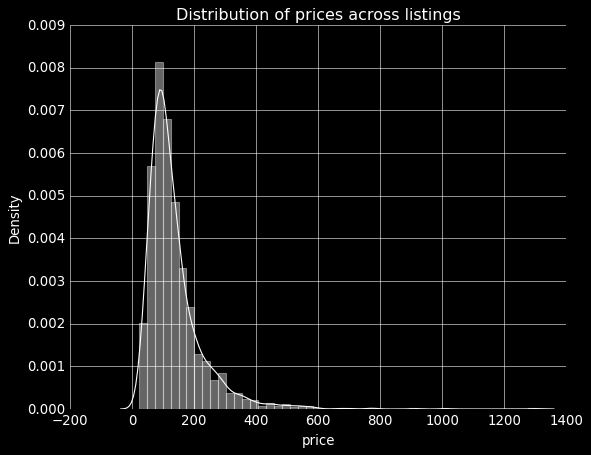

In [134]:
sns.distplot(listings["price"], color="white")
plt.title("Distribution of prices across listings")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='price'>

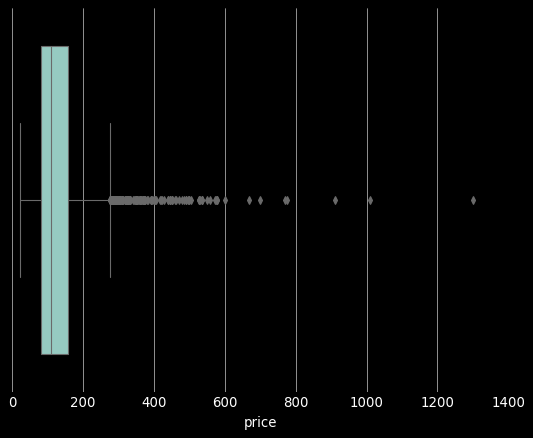

In [135]:
sns.boxplot(listings["price"])

In [136]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder().fit(listings["neighbourhood"])
listings["nbh_cat"] = encoder.transform(listings["neighbourhood"])

In [137]:
listings

,listing_id,name,summary,space,description,neighbourhood,neighbourhood_overview,price,nbh_cat
0,953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,Queen Anne,"Queen Anne is a wonderful, truly functional vi...",170.93,58
1,3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Queen Anne,Upper Queen Anne is a charming neighborhood fu...,1301.82,58
2,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Queen Anne,We are in the beautiful neighborhood of Queen ...,462.74,58
3,5956968,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,Queen Anne,This part of Queen Anne has wonderful views an...,125.63,58
4,1909058,Queen Anne Private Bed and Bath,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,Enjoy a quiet stay in our comfortable 1915 Cra...,Queen Anne,"Close restaurants, coffee shops and grocery st...",80.00,58
...,...,...,...,...,...,...,...,...,...
2378,262764,Fremont Farmhouse,Our 2BR/1 bath home in Fremont's most fun neig...,"1200 ft2 2BR, 1 Bath farmhouse with a large, t...",Our 2BR/1 bath home in Fremont's most fun neig...,Fremont,We love that Fremont is so centrally located t...,191.65,20
2379,8578490,Super Convenient Top Floor Apt,In the true spirit of AirBNB this unit is avai...,The building is older (1970's) so not the mode...,In the true spirit of AirBNB this unit is avai...,Fremont,I am equidistant to Fremont and Wallingford an...,67.78,20
2380,3383329,OF THE TREE & CLOUDS. KID FRIENDLY!,"Of the Tree & Clouds' ""Roots"" apartment is 8 b...","The 1-bedroom, ground-floor Roots apartment is...","Of the Tree & Clouds' ""Roots"" apartment is 8 b...",Fremont,It's taken me a while to figure out why Fremon...,102.82,20
2381,8101950,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,Fremont,We're located near lots of family fun. Woodlan...,359.00,20


<AxesSubplot:title={'center':'Density of neighbourhoods across listings data'}, xlabel='count', ylabel='neighbourhood'>

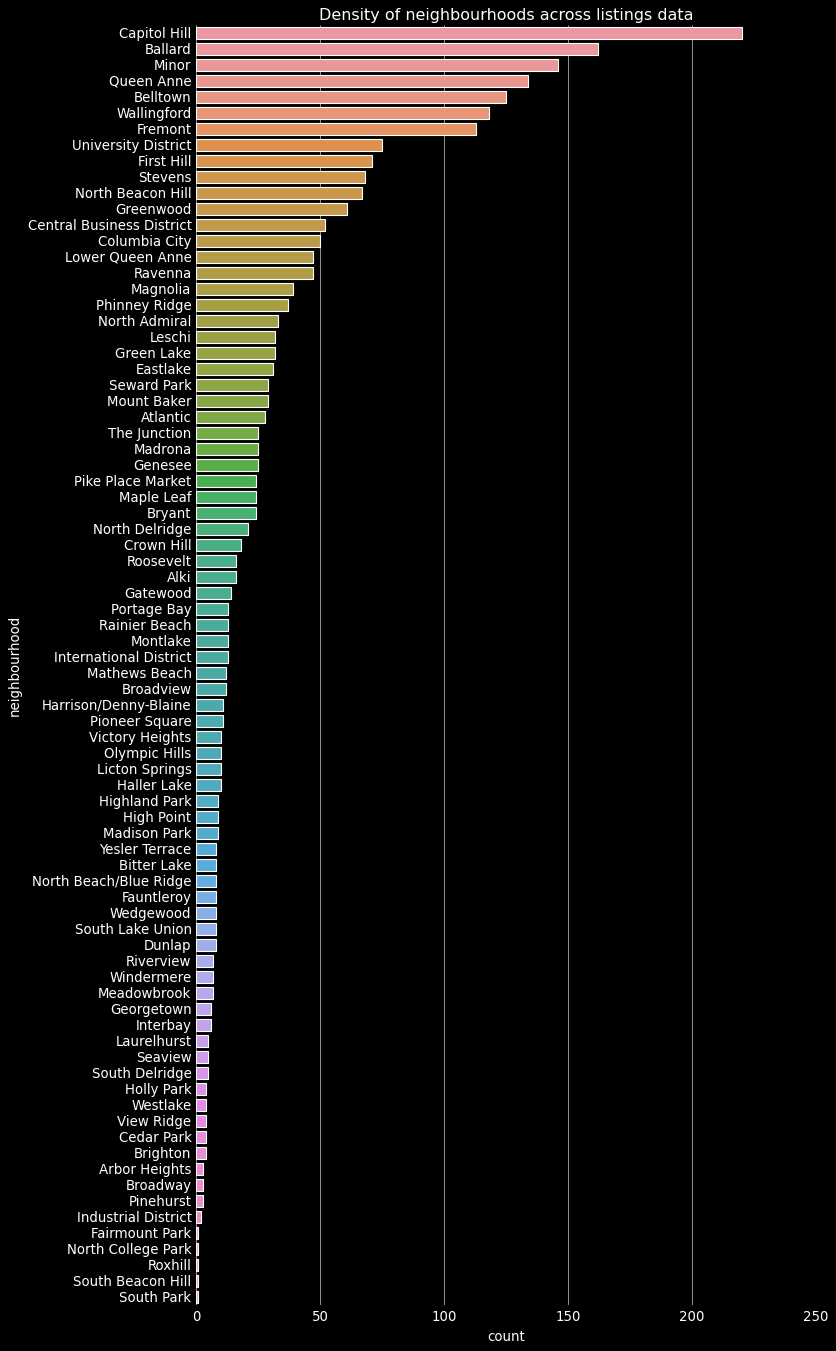

In [138]:
plt.figure(figsize=(10,20))
plt.title("Density of neighbourhoods across listings data")
sns.countplot(y=listings["neighbourhood"], order=listings["neighbourhood"].value_counts().to_frame().reset_index()["index"])

In [139]:
top_expensive = listings.groupby("neighbourhood")["price"].mean().to_frame().reset_index().sort_values(["price"], ascending=False).iloc[:10]
top_expensive

,neighbourhood,price
17,Fairmount Park,370.000000
77,Westlake,335.560000
57,Portage Bay,259.749231
31,Industrial District,242.015000
0,Alki,215.756250
12,Central Business District,208.536538
54,Pike Place Market,202.911667
66,South Beacon Hill,202.640000
4,Belltown,192.961280
58,Queen Anne,188.601418


In [140]:
top_cheap = listings.groupby("neighbourhood")["price"].mean().to_frame().reset_index().sort_values(["price"], ascending=False).iloc[-10:].iloc[::-1]
top_cheap

,neighbourhood,price
30,Holly Park,50.000000
63,Roxhill,60.000000
52,Olympic Hills,65.986000
15,Dunlap,69.513750
28,High Point,70.940000
14,Crown Hill,76.774444
76,Wedgewood,78.022500
23,Georgetown,78.705000
5,Bitter Lake,78.936250
61,Riverview,81.458571


Text(0.5, 0, 'Mean listing price')

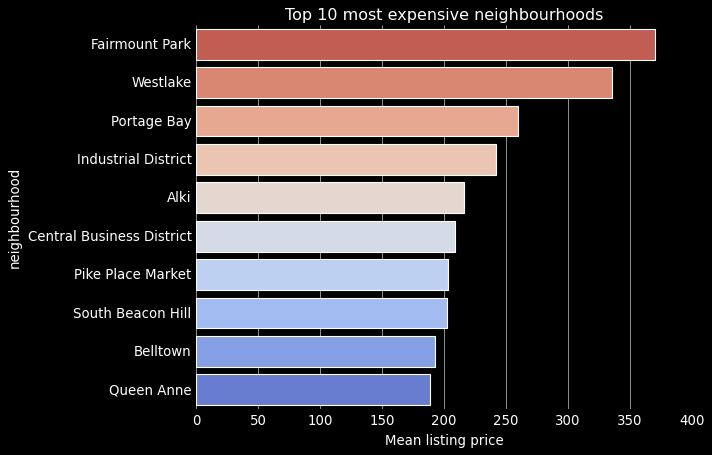

In [141]:
plt.title("Top 10 most expensive neighbourhoods")
sns.barplot(x=top_expensive["price"],y=top_expensive["neighbourhood"], palette="coolwarm_r")
plt.xlabel("Mean listing price")

Text(0.5, 0, 'Mean listing price')

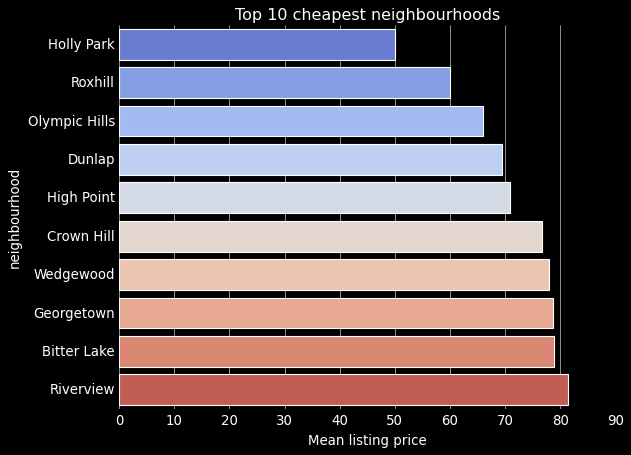

In [142]:
plt.title("Top 10 cheapest neighbourhoods")
sns.barplot(x=top_cheap["price"],y=top_cheap["neighbourhood"], palette="coolwarm")
plt.xlabel("Mean listing price")

In [143]:
def AdjectivesCollector(text_to_process):
    adjs = []
    sentences = nltk.sent_tokenize(text_to_process)

    for sentence in sentences:
         for word,pos in nltk.pos_tag(nltk.word_tokenize(str(sentence))):
             if (pos == 'JJ'):
                 adjs.append(word)
    return adjs

In [144]:
full_adj_list = []
for i in range(len(listings)):
    a = AdjectivesCollector(listings["neighbourhood_overview"][i])
    full_adj_list.append(a)

In [145]:
listings["adjectives"] = full_adj_list

In [146]:
neighbourhoods = listings["neighbourhood"].unique()

In [147]:
adjectives_per_neighbourhood = listings.groupby(["neighbourhood"])["adjectives"].agg(np.sum).to_frame().reset_index()

In [148]:
n_listings = listings["neighbourhood"].value_counts().to_frame().reset_index()
n_listings.rename(columns={"index": "neighbourhood","neighbourhood":"n_listings"},inplace=True)

In [149]:
adjectives_per_neighbourhood = adjectives_per_neighbourhood.merge(n_listings)

In [150]:
adjectives_per_neighbourhood["n_words"] = adjectives_per_neighbourhood["adjectives"].apply(np.size)

In [151]:
listings["neigh_description_array"] = listings["neighbourhood_overview"].apply(lambda x: [str(x)])
adjectives_per_neighbourhood["corpus"] = listings.groupby(["neighbourhood"])["neigh_description_array"].agg(np.sum).to_frame().reset_index()["neigh_description_array"]

In [152]:
adjectives_per_neighbourhood

,neighbourhood,adjectives,n_listings,n_words,corpus
0,Alki,"[short, high-energy, quiet, peaceful, enough, ...",16,100,[Alki beach is one of the largest stretches of...
1,Arbor Heights,"[nice, residential, ten, west, quiet, quick, h...",3,14,"[nice residential neighborhood, away from the ..."
2,Atlantic,"[quick, ~, ~, Asian, east, outside, active, ur...",28,195,[We are located in the Central District betwee...
3,Ballard,"[Norwegian, unique, local, major, great, Noble...",162,1115,"[Ballard is a quaint, Norwegian neighborhood. ..."
4,Belltown,"[AWESOME, major, public, major, direct, pike, ...",125,621,[This neighborhood is AWESOME! We are: - 1 str...
...,...,...,...,...,...
75,Wallingford,"[Short, main, out-of-this-world, burke-gillman...",118,739,[About the 'hood: Short walk to Wallingford a...
76,Wedgewood,"[northeast, peaceful, residential, public, mix...",8,34,"[Located in northeast Seattle, Wedgwood is a p..."
77,Westlake,"[central, main, central, other, blue, perfect,...",4,10,[Proximity to all neighborhoods in Seattle. It...
78,Windermere,"[several, Several, short, safe, beautiful, sho...",7,29,"[The apartment is located in a very quaint, qu..."


In [153]:
from nltk import FreqDist

In [154]:
#absolute freqdist
array_freqdist = []
for i in range(len(adjectives_per_neighbourhood)):
    freq = FreqDist(adjectives_per_neighbourhood["adjectives"][i])
    most_common = freq.most_common(30)
    for i in range(len(most_common)):
        most_common[i] = list(most_common[i])
    array_freqdist.append(most_common)

In [155]:
#relative freqdist (*)
array_freqdist2 = []
for i in range(len(adjectives_per_neighbourhood)):
    freq = FreqDist(adjectives_per_neighbourhood["adjectives"][i])
    most_common = freq.most_common(30)
    
    n_words = adjectives_per_neighbourhood["n_words"][i]
    
    for i in range(len(most_common)):
        most_common[i] = list(most_common[i])
        most_common[i][1] = most_common[i][1]/n_words
        
    array_freqdist2.append(most_common)

**(*) Note:** I divided the number of appeareances of the word by the total number of adjectives in order to determine the significance of the word's ocurrence as the density of listings across neighbourhoods varies greatly.

In [156]:
adjectives_per_neighbourhood["freqdist_adjs"] = array_freqdist
adjectives_per_neighbourhood["freqdist_adjs_relative"] = array_freqdist2

In [157]:
adjectives_per_neighbourhood.head(50)

,neighbourhood,adjectives,n_listings,n_words,corpus,freqdist_adjs,freqdist_adjs_relative
0,Alki,"[short, high-energy, quiet, peaceful, enough, ...",16,100,[Alki beach is one of the largest stretches of...,"[[short, 5], [quiet, 5], [great, 4], [enough, ...","[[short, 0.05], [quiet, 0.05], [great, 0.04], ..."
1,Arbor Heights,"[nice, residential, ten, west, quiet, quick, h...",3,14,"[nice residential neighborhood, away from the ...","[[quick, 2], [nice, 1], [residential, 1], [ten...","[[quick, 0.14285714285714285], [nice, 0.071428..."
2,Atlantic,"[quick, ~, ~, Asian, east, outside, active, ur...",28,195,[We are located in the Central District betwee...,"[[quiet, 8], [great, 6], [urban, 5], [easy, 5]...","[[quiet, 0.041025641025641026], [great, 0.0307..."
3,Ballard,"[Norwegian, unique, local, major, great, Noble...",162,1115,"[Ballard is a quaint, Norwegian neighborhood. ...","[[great, 72], [downtown, 26], [quiet, 25], [ma...","[[great, 0.06457399103139014], [downtown, 0.02..."
4,Belltown,"[AWESOME, major, public, major, direct, pike, ...",125,621,[This neighborhood is AWESOME! We are: - 1 str...,"[[downtown, 25], [many, 22], [few, 20], [great...","[[downtown, 0.040257648953301126], [many, 0.03..."
5,Bitter Lake,"[hustle/bustle/traffic, easy, 15-20, easy, nor...",8,30,[Family neighborhood in North Seattle - less h...,"[[north, 3], [many, 3], [various, 3], [easy, 2...","[[north, 0.1], [many, 0.1], [various, 0.1], [e..."
6,Brighton,"[great, diverse, different, vibrant, excellent...",4,42,[Our neighborhood is great! We are located in ...,"[[great, 3], [diverse, 3], [different, 2], [vi...","[[great, 0.07142857142857142], [diverse, 0.071..."
7,Broadview,"[Quiet, residential, northern, quiet, numerous...",12,50,"[Quiet and convenient!, The residential neighb...","[[residential, 3], [quiet, 3], [many, 3], [bea...","[[residential, 0.06], [quiet, 0.06], [many, 0...."
8,Broadway,"[quiet, instant, quiet, eclectic, downtown, gr...",3,15,[Being a block away from interesting Broadway ...,"[[quiet, 2], [fantastic, 2], [instant, 1], [ec...","[[quiet, 0.13333333333333333], [fantastic, 0.1..."
9,Bryant,"[ideal, nearby, Many, fine, new, easy, bird, m...",24,169,[Rosie's Roost is an ideal location for playin...,"[[quiet, 11], [safe, 10], [great, 10], [reside...","[[quiet, 0.0650887573964497], [safe, 0.0591715..."


In [158]:
#irrelevant words
quality_filter = ["other","more","many","local","short","public","private","quick","ten","half","free","easy","close","many","several","-Seattle","few","pedestrian",
                 "best","true","usual","most","much","*","whole","next","live","downtown","ethnic","main","own","first","second","third","nearby","multiple","5-10",
                 "Seattle-wide","20-30","2-3","two-minute","website","north","away","Nearby","away-","-Pike","various"]

In [159]:
def DescribeNeighbourhoodPlot(neigh_name,limit_words):
    neighbourhood_data = adjectives_per_neighbourhood.loc[adjectives_per_neighbourhood["neighbourhood"]==neigh_name]
    fd = neighbourhood_data["freqdist_adjs_relative"].any()
    
    #quality filter
    save_to_delete = []
    for i in range(len(fd)):
        if fd[i][0] in quality_filter:
            save_to_delete.append([fd[i][0],fd[i][1]])
    for i in range(len(save_to_delete)):
        fd.remove(save_to_delete[i])
        
    fd = fd[:limit_words]

    col_w = []
    col_f = []
    
    for i in range(len(fd)):
        col_w.append(fd[i][0])
        col_f.append(fd[i][1]*100)
    
    
    plt.figure(figsize=(15,10))
    sns.barplot(col_w,col_f, palette="cool", alpha=.8)
    plt.ylabel("(%) of occurences in corpus")
    plt.title(f"What is it like in {neigh_name}, Seattle? (according to Airbnb listings descriptions data)")

In [160]:
def DescribeNeighbourhoodOutput(neigh_name,limit_words):
    neighbourhood_data = adjectives_per_neighbourhood.loc[adjectives_per_neighbourhood["neighbourhood"]==neigh_name]
    fd = neighbourhood_data["freqdist_adjs"].any()
    
    #quality filter
    save_to_delete = []
    for i in range(len(fd)):
        if fd[i][0] in quality_filter:
            save_to_delete.append([fd[i][0],fd[i][1]])
    for i in range(len(save_to_delete)):
        fd.remove(save_to_delete[i])
        
    fd = fd[:limit_words]

    col_w = []
    col_f = []
    
    for i in range(len(fd)):
        col_w = to_ret = fd[i][0]

    return col_w

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


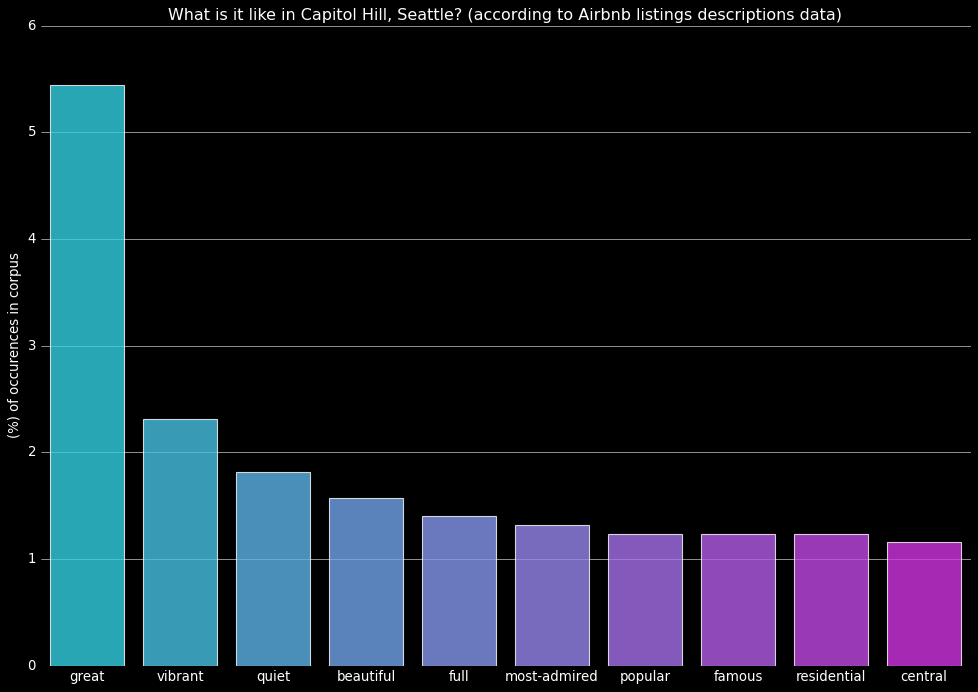

In [161]:
DescribeNeighbourhoodPlot("Capitol Hill",10)

This function outputs filtered adjectives in the neighbourhood description and plots them in a bar chart by their percentage of occurence in the full-length list. Let's see if more information can be obtained through the use of collocations.

In [162]:
from nltk import TrigramCollocationFinder
to_process = np.array(adjectives_per_neighbourhood["corpus"][10]).flatten() # [10]: Capitol Hill
to_process = ''.join(to_process)
tokens = nltk.word_tokenize(to_process)
trigram_measures    = nltk.collocations.TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(tokens)
scored = finder.score_ngrams(trigram_measures.pmi)


In [163]:
scored

[(('ARTS', 'VIRETTA/KURT', 'COBAIN'), 27.95169593601357),
 (('BALTIC', 'ROOM', 'STUMPTOWN'), 27.95169593601357),
 (('Beer', 'Bocce', 'Brats'), 27.95169593601357),
 (('CENTER', 'KEY', 'ARENA'), 27.95169593601357),
 (('CHUTNEYS', 'CANTURBURY', 'ALE'), 27.95169593601357),
 (('COASTAL', 'KITCHEN', 'CHUTNEYS'), 27.95169593601357),
 (('CUISINE', 'HOPVINE', 'SMITH'), 27.95169593601357),
 (('Cha', 'Cha-', 'Luchador'), 27.95169593601357),
 (('Cha-', 'Luchador', 'themed'), 27.95169593601357),
 (('EGYPTIAN', 'ODDFELLOWS', 'HALL'), 27.95169593601357),
 (('FARMERS', 'MARKET', 'DICKS'), 27.95169593601357),
 (('FROM', 'MY', 'APARTMENT'), 27.95169593601357),
 (('IMAX/PACIFIC', 'SCIENCE', 'CENTER'), 27.95169593601357),
 (('Isamu', 'Noguchi', 'sculpture'), 27.95169593601357),
 (('Jamjuree', 'beside', 'them'), 27.95169593601357),
 (('KEY', 'ARENA', 'NortCapitol'), 27.95169593601357),
 (('KITCHEN', 'CHUTNEYS', 'CANTURBURY'), 27.95169593601357),
 (('Kurt', 'Cobain', 'used'), 27.95169593601357),
 (('LANDMAR

A fair chunk of information is revealed when looking for Trigram collocations. Anyway it is not that relevant for the purpose of describing the style of a neighbourhood overall, as the previous function already performs that task fairly great.

In [164]:
neighbourhoods_characterized = []
for i in range(len(adjectives_per_neighbourhood)):
    neigh = adjectives_per_neighbourhood["neighbourhood"][i]
    returned = DescribeNeighbourhoodOutput(neigh,1)
    if returned==[]:
        returned = "none"
    neighbourhoods_characterized.append(returned)

In [165]:
len(neighbourhoods_characterized)

80

In [166]:
neighbourhoods_characterized

['quiet',
 'nice',
 'quiet',
 'great',
 'great',
 'residential',
 'great',
 'residential',
 'quiet',
 'quiet',
 'great',
 'little',
 'central',
 'great',
 'quiet',
 'diverse',
 'great',
 'none',
 'great',
 'great',
 'great',
 'quiet',
 'great',
 'industrial',
 'great',
 'great',
 'quiet',
 'Japanese',
 'quiet',
 'quiet',
 'peaceful',
 'little',
 'right',
 'great',
 'quiet',
 'quiet',
 'quiet',
 'great',
 'popular',
 'beautiful',
 'quiet',
 'new',
 'friendly',
 'peaceful',
 'great',
 'commercial',
 'great',
 'great',
 'quiet',
 'great',
 'ideal',
 'quiet',
 'Quiet',
 'great',
 'great',
 'outside',
 'historic',
 'great',
 'great',
 'delicious',
 'quiet',
 'quiet',
 'great',
 'none',
 'great',
 'great',
 'Quiet',
 'Mexican',
 'great',
 'little',
 'great',
 'quiet',
 'diverse',
 'walkable',
 'professional',
 'great',
 'quiet',
 'central',
 'great',
 'small']

In [167]:
#CREATE MAP COLORED BY NEIGHBOURHOOD WORD

In [168]:
import geoplot as gplt
import geopandas as gpd

In [169]:
usa_cities = "https://raw.githubusercontent.com/ResidentMario/geoplot-data/master/usa-cities.geojson"
usa_cities = gpd.read_file(usa_cities)
usa_cities["geometry"]

0       POINT (-101.29627 48.23251)
1        POINT (-97.03285 47.92526)
2        POINT (-98.70844 46.91054)
3        POINT (-96.78980 46.87719)
4       POINT (-102.78962 46.87918)
                   ...             
3661     POINT (-73.94956 40.65009)
3662     POINT (-73.79745 40.75016)
3663     POINT (-74.14981 40.58328)
3664     POINT (-71.33303 41.98405)
3665     POINT (-80.29498 26.16730)
Name: geometry, Length: 3666, dtype: geometry

In [170]:
seattle_city_limits = "https://raw.githubusercontent.com/ivanachillee/seattle-senses/main/expansion_data/seattle-city-limits.geojson"
seattle_neighbourhoods = "https://raw.githubusercontent.com/ivanachillee/seattle-senses/main/expansion_data/seattle_neighbourhoods_coordinates.geojson"

In [171]:
seattle_map = gpd.read_file(seattle_city_limits)
seattle_neighbourhoods = gpd.read_file(seattle_neighbourhoods)

In [172]:
neighbourhoods_characterized = np.array(neighbourhoods_characterized)

In [173]:
nc = pd.DataFrame()
nc["Neighbourhood"] = adjectives_per_neighbourhood["neighbourhood"].unique()
nc["Characteristic"] = neighbourhoods_characterized

In [174]:
nc["Characteristic"].unique()

array(['quiet', 'nice', 'great', 'residential', 'little', 'central',
       'diverse', 'none', 'industrial', 'Japanese', 'peaceful', 'right',
       'popular', 'beautiful', 'new', 'friendly', 'commercial', 'ideal',
       'Quiet', 'outside', 'historic', 'delicious', 'Mexican', 'walkable',
       'professional', 'small'], dtype=object)

In [175]:
seattle_neighbourhoods = seattle_neighbourhoods.merge(nc)

In [206]:
seattle_neighbourhoods["Characteristic"] = seattle_neighbourhoods["Characteristic"].str.lower()

In [176]:
to_pass = seattle_neighbourhoods[(seattle_neighbourhoods["Characteristic"]=="great")]
sc2 = np.full((len(to_pass),),30)
sc2[0] = 29

/opt/conda/lib/python3.7/site-packages/descartes/patch.py:87: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return PathPatch(PolygonPath(polygon), **kwargs)


Text(0.5, 1.0, 'Neighbourhoods in Seattle that are "great"')

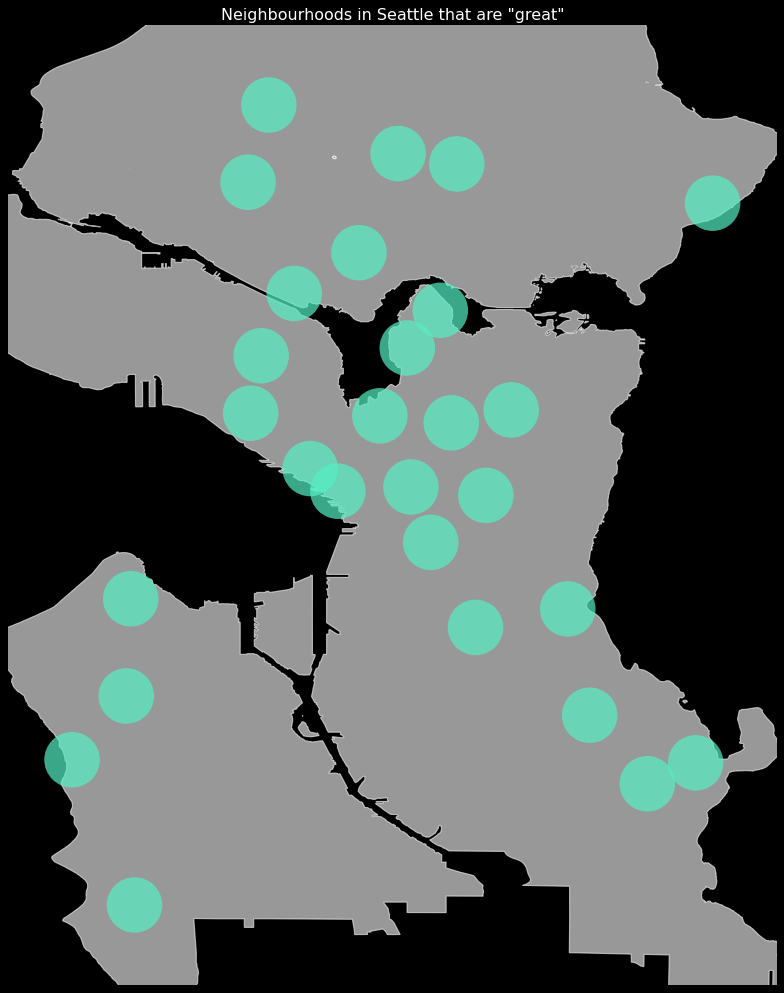

In [177]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ax = gplt.polyplot(seattle_map, color="white", alpha=0.6, figsize=(15,15))
gplt.pointplot(to_pass,alpha=0.7, ax=ax, scale=sc2, limits=(1,50), edgecolor="none", color="#55efc4")
plt.title('Neighbourhoods in Seattle that are "great"')

In [178]:
to_pass = seattle_neighbourhoods[(seattle_neighbourhoods["Characteristic"]=="quiet") | (seattle_neighbourhoods["Characteristic"]=="Quiet")]
sc2 = np.full((len(to_pass),),30)
sc2[0] = 29

Text(0.5, 1.0, 'Neighbourhoods in Seattle that are "quiet"')

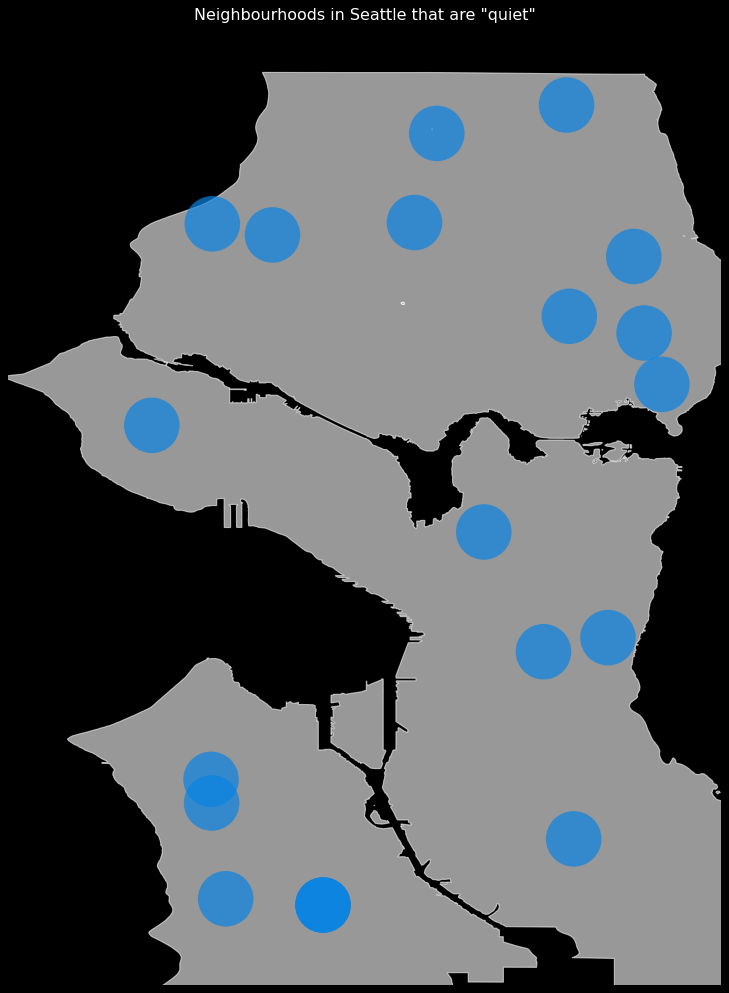

In [179]:
ax = gplt.polyplot(seattle_map, color="white", alpha=0.6, figsize=(15,15))
gplt.pointplot(to_pass,alpha=0.7, ax=ax, scale=sc2, limits=(1,50), edgecolor="none", color="#0984e3")
plt.title('Neighbourhoods in Seattle that are "quiet"')

## The statistics of the adjectivized

Can the narrated description of the neighbourhoods just by themselves help to understand price phenomenons of renting spaces?

In [180]:
def NhoodOP(neigh_name,limit_words):
    neighbourhood_data = adjectives_per_neighbourhood.loc[adjectives_per_neighbourhood["neighbourhood"]==neigh_name]
    fd = neighbourhood_data["freqdist_adjs"].any()
    
    #quality filter
    save_to_delete = []
    for i in range(len(fd)):
        if fd[i][0] in quality_filter:
            save_to_delete.append([fd[i][0],fd[i][1]])
    for i in range(len(save_to_delete)):
        fd.remove(save_to_delete[i])
        
    fd = fd[:limit_words]

    col_w = []
    col_f = []
    
    for i in range(len(fd)):
        col_w.append(fd[i][0])
        col_f.append(fd[i][1])

    return (col_w,col_f)

In [182]:
seattle_neighbourhoods

,id,Neighbourhood,geometry,Characteristic
0,0,Alki,POINT (-122.42082 47.57627),quiet
1,1,Arbor Heights,POINT (-122.37819 47.50955),nice
2,2,Atlantic,POINT (-122.30806 47.59694),quiet
3,3,Ballard,POINT (-122.38500 47.67700),great
4,4,Belltown,POINT (-122.34650 47.61322),great
...,...,...,...,...
75,75,Wallingford,POINT (-122.33611 47.65917),great
76,76,Wedgewood,POINT (-122.28667 47.69056),quiet
77,77,Westlake,POINT (-122.34111 47.63167),central
78,78,Windermere,POINT (-122.26083 47.66972),great


In [192]:
nhpr = listings.groupby("neighbourhood")["price"].mean().to_frame().reset_index()
nhpr = nhpr.rename({'neighbourhood': 'Neighbourhood'}, axis=1)
seattle_neighbourhoods = seattle_neighbourhoods.merge(nhpr, on="Neighbourhood") #load price data

In [204]:
seattle_neighbourhoods.sort_values("price", ascending=False)[-10:]

,id,Neighbourhood,geometry,Characteristic,price
61,61,Riverview,POINT (-122.36028 47.53694),quiet,81.458571
5,5,Bitter Lake,POINT (-122.35100 47.72600),residential,78.936250
23,23,Georgetown,POINT (-122.32056 47.54306),industrial,78.705000
76,76,Wedgewood,POINT (-122.28667 47.69056),quiet,78.022500
14,14,Crown Hill,POINT (-122.37225 47.69567),quiet,76.774444
28,28,High Point,POINT (-122.38667 47.56111),quiet,70.940000
15,15,Dunlap,POINT (-122.27417 47.52611),diverse,69.513750
52,52,Olympic Hills,POINT (-122.30258 47.72644),Quiet,65.986000
63,63,Roxhill,POINT (-122.36028 47.53694),none,60.000000
30,30,Holly Park,POINT (-122.28694 47.53917),peaceful,50.000000


Text(0.5, 0, 'Mean Price of Listing')

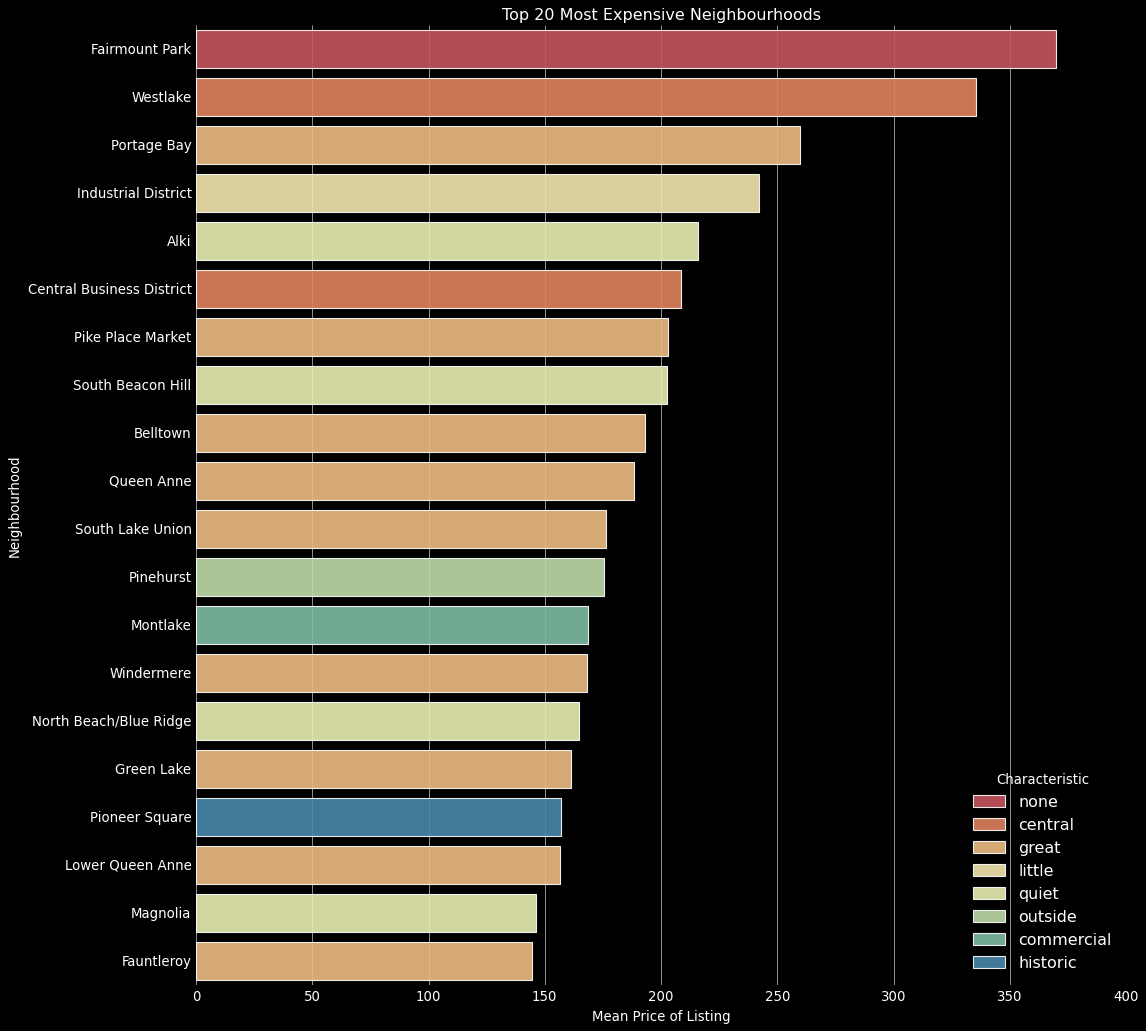

In [270]:
plt.figure(figsize=(15,15))
plt.title("Top 20 Most Expensive Neighbourhoods")
sns.barplot(y="Neighbourhood",x="price", hue="Characteristic", palette="Spectral", alpha=.9, dodge=False, data=seattle_neighbourhoods.sort_values("price", ascending=False)[:20])
plt.xlabel("Mean Price of Listing")

Text(0.5, 0, 'Mean Price of Listing')

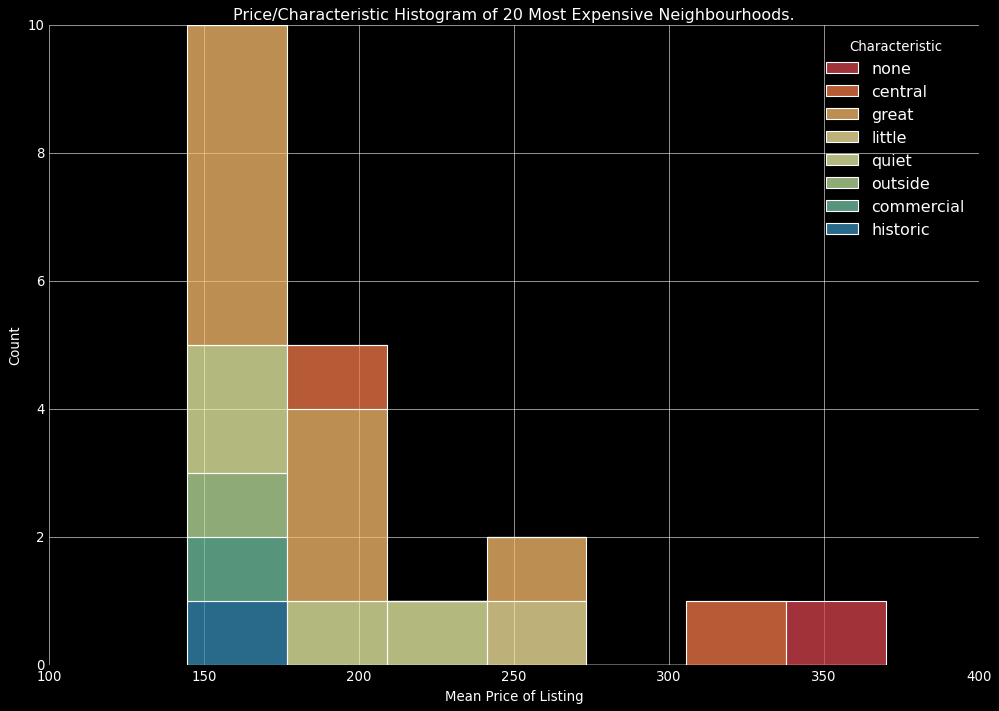

In [271]:
plt.figure(figsize=(15,10))
plt.title("Price/Characteristic Histogram of 20 Most Expensive Neighbourhoods.")
sns.histplot(x="price", multiple="stack", hue="Characteristic", palette="Spectral",data=seattle_neighbourhoods.sort_values("price", ascending=False)[:20])
plt.xlabel("Mean Price of Listing")

It seems that the description **great** dominates the top 20 most expensive neighbourhoods.

Text(0.5, 0.98, 'Top 20 Most Expensive Neighbourhoods')

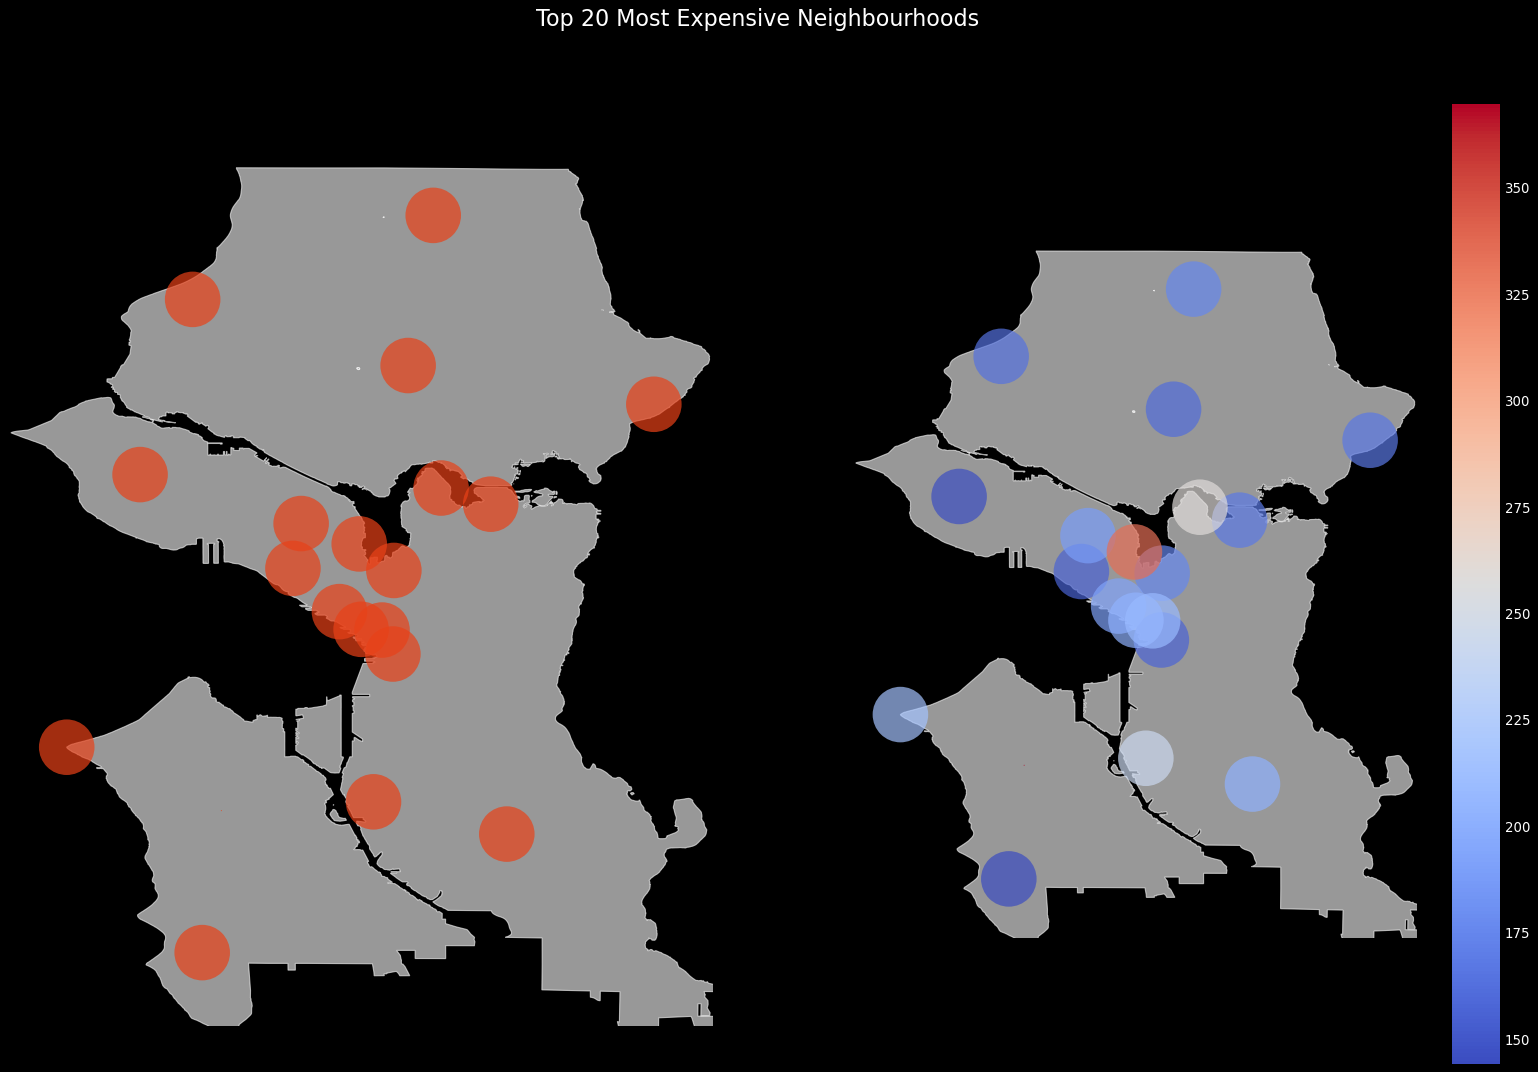

In [308]:
fig, axs = plt.subplots(1, 2, figsize=(25,15))
to_pass = seattle_neighbourhoods.sort_values("price", ascending=False)[:20]
sc2 = np.full((len(to_pass),),30)
sc2[0] = 29

ax1 = gplt.polyplot(seattle_map, color="white", alpha=0.6, figsize=(15,15), ax=axs[0])
gplt.pointplot(to_pass,alpha=0.7, ax=ax1, scale=sc2, limits=(1,50), edgecolor="none", color="#e84118")

ax2 = gplt.polyplot(seattle_map, color="white", alpha=0.6, figsize=(15,15), ax=axs[1])
gplt.pointplot(to_pass,alpha=0.7, ax=ax2, scale=sc2, limits=(1,50), edgecolor="none", hue=to_pass["price"], cmap="coolwarm", legend=True)

fig.suptitle("Top 20 Most Expensive Neighbourhoods", size=20)


The majority of the most expensive neighbourhoods are located in the centre of Seattle.

Text(0.5, 0, 'Mean Price of Listing')

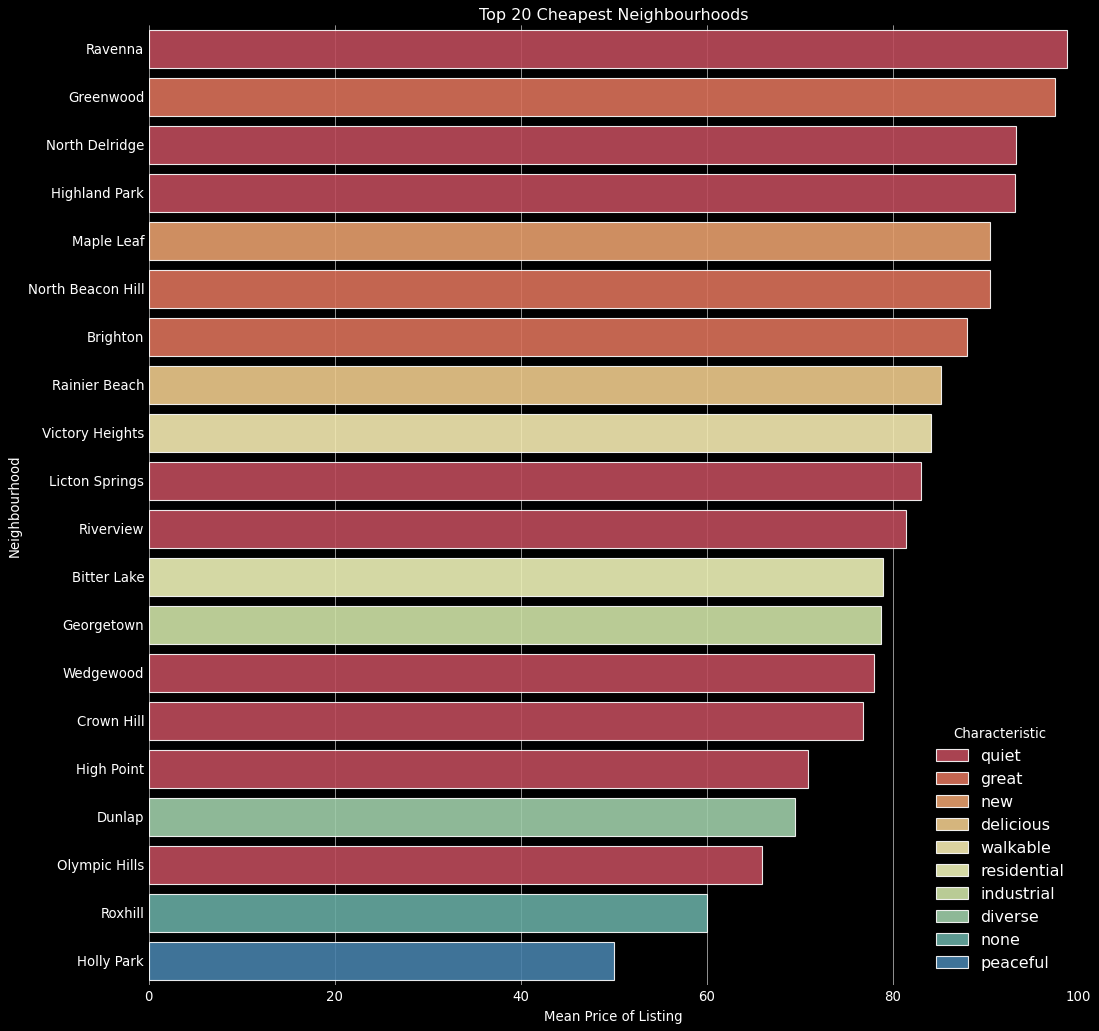

In [272]:
plt.figure(figsize=(15,15))
plt.title("Top 20 Cheapest Neighbourhoods")
sns.barplot(y="Neighbourhood",x="price", hue="Characteristic", palette="Spectral", alpha=.9,dodge=False, data=seattle_neighbourhoods.sort_values("price", ascending=False)[-20:])
plt.xlabel("Mean Price of Listing")

Text(0.5, 0, 'Mean Price of Listing')

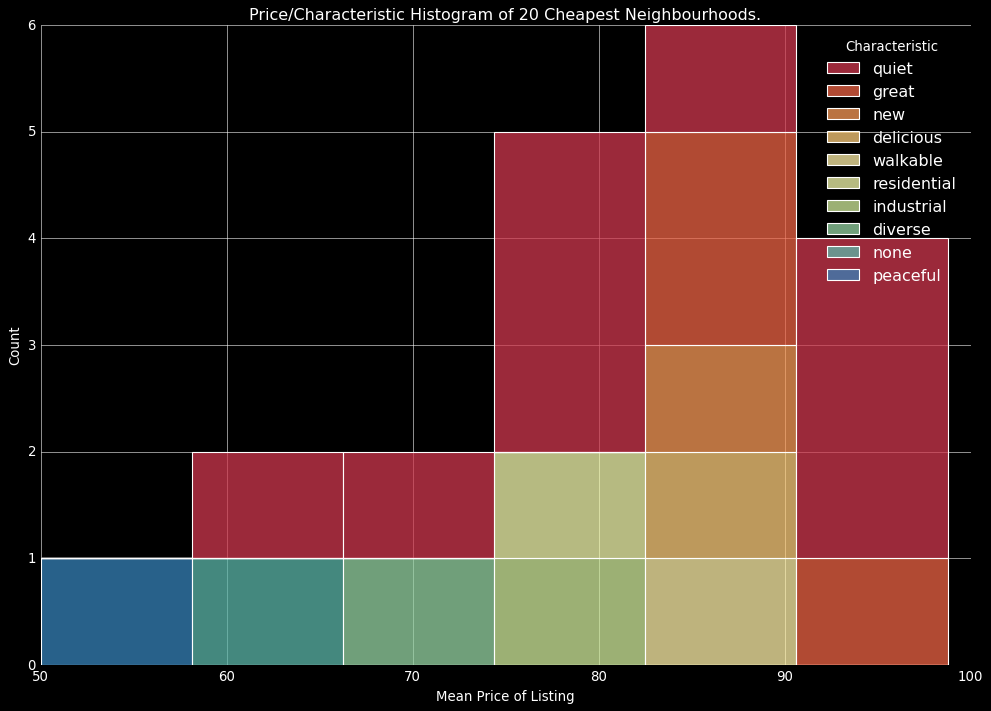

In [273]:
plt.figure(figsize=(15,10))
plt.title("Price/Characteristic Histogram of 20 Cheapest Neighbourhoods.")
sns.histplot(x="price", multiple="stack", hue="Characteristic", palette="Spectral",data=seattle_neighbourhoods.sort_values("price", ascending=False)[-20:])
plt.xlabel("Mean Price of Listing")

Here, it seems that the description **quiet** dominates the top 20 cheapest neighbourhoods.

Text(0.5, 0.98, 'Top 20 Cheapest Neighbourhoods')

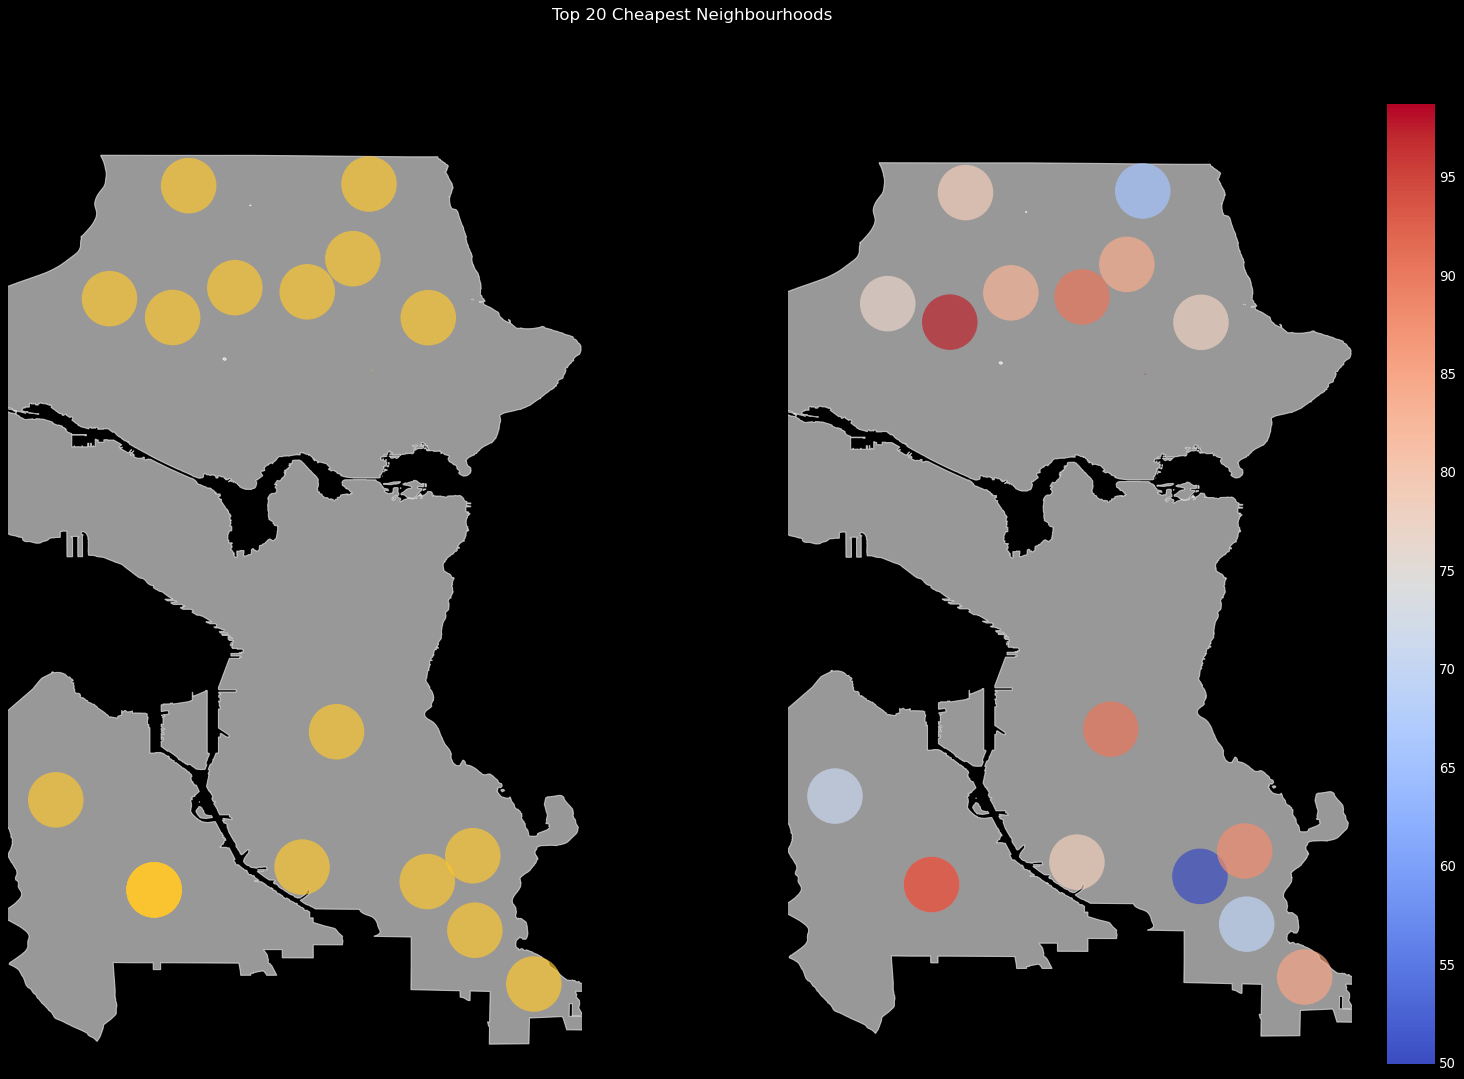

In [306]:
fig, axs = plt.subplots(1, 2, figsize=(25,15))
to_pass = seattle_neighbourhoods.sort_values("price", ascending=False)[-20:]
sc2 = np.full((len(to_pass),),30)
sc2[0] = 29

ax1 = gplt.polyplot(seattle_map, color="white", alpha=0.6, figsize=(15,15), ax=axs[0])
gplt.pointplot(to_pass,alpha=0.7, ax=ax1, scale=sc2, limits=(1,50), edgecolor="none", color="#fbc531")

ax2 = gplt.polyplot(seattle_map, color="white", alpha=0.6, figsize=(15,15), ax=axs[1])
gplt.pointplot(to_pass,alpha=0.7, ax=ax2, scale=sc2, limits=(1,50), edgecolor="none", hue=to_pass["price"], cmap="coolwarm", legend=True)

fig.suptitle("Top 20 Cheapest Neighbourhoods", size=20)


It can be seen that the cheapest neighbourhoods are located on the edges of Seattle, on the contrary of the most expensive ones which are more densely concentrated in the center of the City.